In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.optimize as so
import scipy.linalg as sl
import scipy.integrate as si
import matplotlib.pyplot as plt
from numba import njit
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

<h3>Generate Training Data</h3>

**In other words, solve the forward problem**

In [2]:
@njit
def toeplitz(r, c):
    c = np.asarray(c).ravel()
    r = np.asarray(r).ravel()
    # Form a 1-D array containing a reversed c followed by r[1:] that could be
    # strided to give us toeplitz matrix.
    vals = np.concatenate((c[::-1], r[1:]))
    out_shp = len(c), len(r)
    n = vals.strides[0]
    return np.lib.stride_tricks.as_strided(vals[len(c)-1:], shape=out_shp, strides=(-n, n)).copy()

In [3]:
# set number of Fourier basis 
nfb = 128

# set radius of spatial domain
radius = 16

# create vector of real space points for plotting
nx = 1024
xvec = np.linspace(-radius, radius, nx)

# construct matrix to convert Fourier basis coefficients 
# into real space values
nvec = np.arange(-nfb, nfb+1) # nvec=-nfb,...,0,...,nfb
convmat = np.exp(1j * np.pi * np.outer(nvec, xvec) / radius) / np.sqrt(2 * radius)

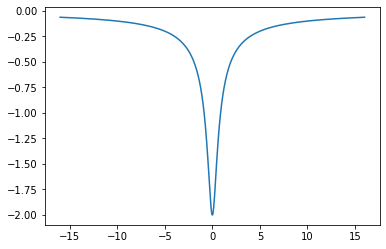

In [12]:
# define potential for generating training data

def v(x, choice=0):
    if choice == 0:
        # dimensionless quantum harmonic oscillator potential
        return 0.5 * x**2
    elif choice == 1:
        # rescaled symmetric double well potential
        return 0.0025*(x**2 - 25)**2
    elif choice == 2:
        # scaled asymmetric double well potential
        return 0.0003*((x-3)**4 + 10*(x-5)**3)
    elif choice == 3:
        # soft coulomb potential
        return -1 / np.sqrt(x**2 + 0.25)
    else:
        print('Potential Function: Choice not recognised.')
        return None

# compute true potential
vchoice = 3
vtrue = v(xvec, choice=vchoice)

# plot true potential
plt.plot(xvec, vtrue)
plt.show()

In [5]:
# set number of Gaussian basis
ng = 16

# vector of Gaussian basis centers in real space
xg = np.linspace(-radius, radius, ng)

---
**Code for Computing minalpha**

In [6]:
# construct a vector of alpha values
alphavals = np.concatenate([np.linspace(0.01, 1, 128), np.linspace(1, 3, 24)])  # np.array([0.06, 0.11967, 0.12393, 0.17933, 0.6, 3])

In [16]:
def grecnormcond(alpha):
    grecgmat = np.exp(-alpha[:, np.newaxis, np.newaxis] * (xg[:,np.newaxis] - xg)**2)
    grecgmatplot = np.exp(-alpha[:, np.newaxis, np.newaxis] * (xvec[:, np.newaxis] - xg) ** 2)

    coeffs = nl.inv(grecgmat) @ v(xg, choice=vchoice)
    greconvtrue = np.einsum('...bc, ...c', grecgmatplot, coeffs)
    # quantify difference between real and reconstructed potentials
    # using the relative norm difference
    return nl.norm(greconvtrue - vtrue, axis=1) / nl.norm(vtrue), nl.cond(grecgmat)

In [ ]:
# compute the relative norm difference between
# true and reconstructed potential as a function of alpha
norms, condnums = grecnormcond(alphavals)
print('Done.')

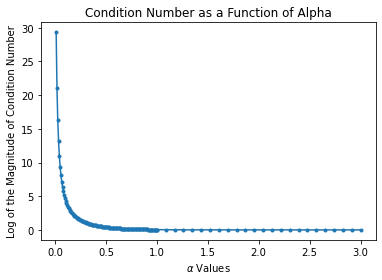

In [42]:
plt.plot(alphavals, np.log(condnums), '.-', label='Condition Nums')
# give a vertical line identifying alpha=0.11967
# plt.vlines(alphavals[1], 0, condnums[1], linestyles=':', colors='black')
# plt.hlines(0, 0, 10, 'r')
plt.xlabel(r'$\alpha$ Values')
# plt.ylim(0, 400)
# plt.xlim(0.25, 1)
plt.ylabel("Log of the Magnitude of Condition Number")
plt.title('Condition Number as a Function of Alpha')
plt.show()

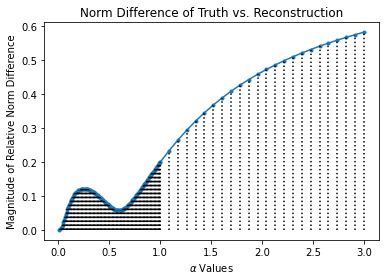

In [19]:
plt.plot(alphavals, norms, '.-', label='Norms')
plt.vlines(alphavals, 0, norms, linestyles=':', colors='black')
# plt.hlines(0, 0, 10, 'r')
plt.xlabel(r'$\alpha$ Values')
# plt.ylim(0, 45)
# plt.xlim(0.25, 1)
plt.ylabel("Magnitude of Relative Norm Difference")
plt.title('Norm Difference of Truth vs. Reconstruction')
plt.show()

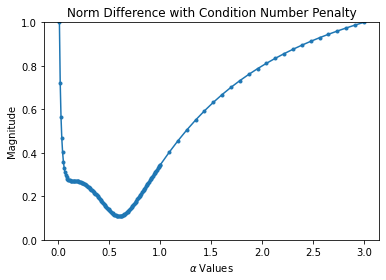

In [27]:
def grecminvec(alpha):
    grecgmat = np.exp(-alpha[:, np.newaxis, np.newaxis] * (xg[:,np.newaxis] - xg)**2)
    grecgmatplot = np.exp(-alpha[:, np.newaxis, np.newaxis] * (xvec[:, np.newaxis] - xg) ** 2)

    coeffs = nl.inv(grecgmat) @ v(xg, choice=vchoice)
    greconvtrue = np.einsum('...bc, ...c', grecgmatplot, coeffs)
    # quantify difference between real and reconstructed potentials
    normvec = nl.norm(greconvtrue - vtrue, axis=1)
    # scale norms so ranges from 0 to 1
    scalednorms = normvec / normvec.max()

    condvec = nl.cond(grecgmat)
    logcondvec = np.log(condvec)
    # scale condition number so ranges from 0 to 1
    scaledcond = logcondvec / logcondvec.max()
    return scalednorms + scaledcond

plt.plot(alphavals, grecminvec(alphavals), '.-')
plt.xlabel(r'$\alpha$ Values')
plt.ylabel("Magnitude")
plt.title('Norm Difference with Condition Number Penalty')
plt.ylim(0, 1)
# plt.xlim(0, 1)
plt.show()

In [13]:
def grecminfn(alpha):
    grecgmat = np.exp(-alpha * (xg[:,np.newaxis] - xg)**2)
    grecgmatplot = np.exp(-alpha * (xvec[:, np.newaxis] - xg) ** 2)

    coeffs = nl.inv(grecgmat) @ v(xg, choice=vchoice)
    greconvtrue = np.einsum('...bc, ...c', grecgmatplot, coeffs)
    # quantify difference between real and reconstructed potentials
    normval = nl.norm(greconvtrue - vtrue)
    # scale norms so ranges from 0 to 1
    scalednorm = normval / nl.norm(vtrue)

    condnum = nl.cond(grecgmat)
    logcondnum = np.log(condnum)

    # scale condition number so ranges from 0 to 1
    return scalednorm + logcondnum / 30, scalednorm, logcondnum / 30

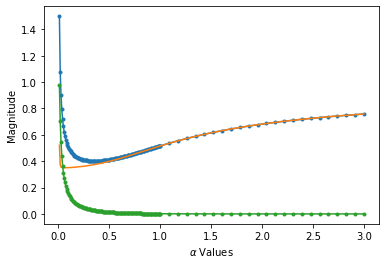

In [14]:
grecminfnrtn = np.zeros((len(alphavals), 3), dtype=float)
for i in range(len(alphavals)):
    grecminfnrtn[i] = grecminfn(alphavals[i])

plt.plot(alphavals, grecminfnrtn[:,0], '.-')
plt.plot(alphavals, grecminfnrtn[:,1], '-')
plt.plot(alphavals, grecminfnrtn[:,2], '.-')
plt.xlabel(r'$\alpha$ Values')
plt.ylabel("Magnitude")
# plt.title('Norm Difference with Condition Number Penalty')
# plt.ylim(0, 1)
# plt.xlim(0, 1)
plt.show()

In [14]:
minalpha = so.minimize(grecminfn, x0=0.5, method='BFGS', jac='3-point', options={'disp': True}).x
print(minalpha)

ValueError: The user-provided objective function must return a scalar value.

---
**Animation: Reconstruction as a Function of Alpha**

In [11]:
def grec(alpha):
    grecgmat = np.exp(-alpha * (xg[:,np.newaxis] - xg)**2)
    grecgmatplot = np.exp(-alpha * (xvec[:, np.newaxis] - xg) ** 2)

    coeffs = nl.inv(grecgmat) @ v(xg)
    greconvtrue = np.einsum('...bc, ...c', grecgmatplot, coeffs)
    return greconvtrue

In [ ]:
# animate the plot of the real potential vs reconstructed

# setup figure and axis for animation
fig, (axfull, axzoom) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axfull.set(xlim=(-(radius+1), (radius+1)), ylim=(-3, 13))
axzoom.set(xlim=(-radius, radius), ylim=(-2.5, 1.5))

# plot the true potential in black
axfull.plot(xvec, vtrue, color='k', marker='.', linestyle='')
axzoom.plot(xvec, vtrue, color='k', marker='.', linestyle='')

# plot a initial reconstructed potential in black
linevrecfull = axfull.plot(xvec, grec(alphavals[0]), color='r', marker='2', linestyle='')[0]
linevreczoom = axzoom.plot(xvec, grec(alphavals[0]), color='r', marker='2', linestyle='')[0]

# plot the alpha value in black text
alphavaltxfull = axfull.text(5, -2.0, f'TEXT', color='black')
alphavaltxzoom = axzoom.text(5, -2.0, f'TEXT', color='black')

# function for animation
def animate(thisalphaval):
    # compute the reconstructed potential
    thisvrec = grec(thisalphaval)
    # update curve
    linevrecfull.set_ydata(thisvrec)
    linevreczoom.set_ydata(thisvrec)

    # compute the relative norm of the difference
    thisnorm = nl.norm(thisvrec - vtrue) / nl.norm(vtrue)
    # update text
    alphavaltxfull.set_text(f'Alpha: {thisalphaval}\nNorm: {thisnorm}')
    alphavaltxzoom.set_text(f'Alpha: {thisalphaval}\nNorm: {thisnorm}')

In [ ]:
# create the animation
anim = FuncAnimation(fig, animate, frames=np.arange(0.0001, 3, 0.005))

# show animation
HTML(anim.to_jshtml())

---

(16, 16)
(1024, 16)


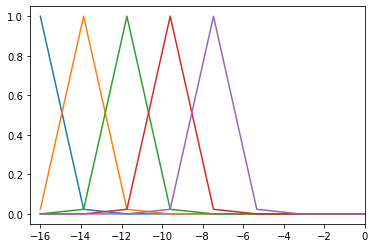

(16,)


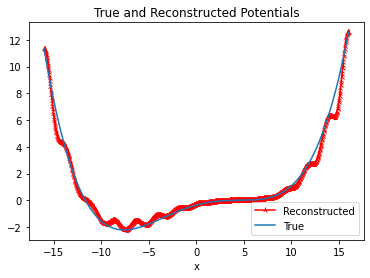

Relative Norm Difference: 0.12676350208037845


In [76]:
# this code computes the coefficients of the true potential in the
# Gaussian basis using minalpha (determined above)

# this is used for computing the Gaussian basis coefficients
gmat = np.exp(-minalpha * (xg[:,np.newaxis] - xg)**2)
print(gmat.shape)

# this is used for converting the Gaussian basis coefficients
# to real space values
gmatplot = np.exp(-minalpha * (xvec[:,np.newaxis] - xg)**2)
print(gmatplot.shape)

# show first 5 basis to check overlap 
for i in range(5):
    plt.plot(xg, np.exp(-minalpha * (xg - xg[i])**2))
plt.xlim((-radius - 0.5, 0))
plt.show()

# this computes the Gaussian basis coefficients
# of the true potential
# We use gmat here because the matrix being inverted
# must be a square matrix
cfftrue = nl.inv(gmat) @ v(xg)
print(cfftrue.shape)

# reconstruct the potential from the Gaussian basis coefficents
reconvtrue = gmatplot @ cfftrue

# plot real potential vs. reconstructed potential
plt.plot(xvec, reconvtrue, '2-r', label='Reconstructed')
plt.plot(xvec, vtrue, label='True')
plt.title('True and Reconstructed Potentials')
plt.xlabel('x')
plt.legend()
plt.show()

print('Relative Norm Difference:', nl.norm(reconvtrue - vtrue) / nl.norm(vtrue))

In [77]:
# this code is for computing the potential matrix and its
# gradient in the Fourier basis given a set of Gaussian
# basis coefficents.
# cff is the vector containing the Gaussian basis coefficents

k = np.pi * np.arange(0, 2*nfb+1) / radius
expmat = np.exp((-k**2 / (4*minalpha))[:, np.newaxis] + (-1j*k[:,np.newaxis]*xg))
gvmatcnst = (1 / (2 * radius)) * np.sqrt(np.pi / minalpha) * expmat

gradgvmat = np.zeros((ng, 2*nfb+1, 2*nfb+1), dtype=np.complex128)
for i in range(ng):
    gradgvmat[i,:]=toeplitz(gvmatcnst.T[i].conj(), gvmatcnst.T[i])
print(gradgvmat.shape)

@njit
def gvmat(cff):
    column = gvmatcnst @ cff.astype(np.complex128)
    row = column.conj()
    return toeplitz(r=row, c=column)

(16, 257, 257)


**Initial State of System**

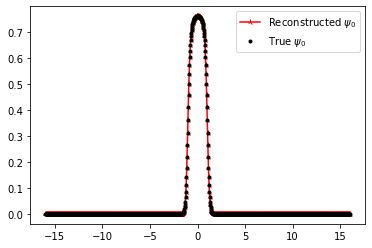

0.00028386310807257967


In [78]:
# this code creates ainit from psi0

# triangular pulse
# def psi0(x):
#     return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])

# parabolic pulse
# def psi0(x):
#     return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])

# hyperbolic secant squared
# def psi0(x):
#     return (np.cosh(x))**(-2)

# Laplace
# def psi0(x):
#     return np.exp(-np.abs(x))

# rounded box function
def psi0(x):
    return 1.0 + np.tanh((1 - x**2)/0.5)

# normalize psi0
norm = np.sqrt(si.quad(lambda x: np.abs(psi0(x))**2, a=-radius, b=radius)[0])
def normpsi0(x):
    return psi0(x)/norm

# transform psi0 to Fourier basis
# step through all nfb Fourbasis and use quadrature method
# to perform integration
vraw = np.zeros(nfb+1, dtype=np.complex128)
for thisn in range(nfb+1):
    def integ(x):
        return (2 * radius) ** (-0.5) * np.exp(-1j * np.pi * thisn * x / radius) * normpsi0(x)
    def rinteg(x):
        return np.real(integ(x))
    def iinteg(x):
        return np.imag(integ(x))
    vraw[thisn] = si.quad(rinteg, a=-radius, b=radius)[0] + 1j * si.quad(iinteg, a=-radius, b=radius)[0]
ainit = np.concatenate([np.conjugate(np.flipud(vraw[1:])), vraw])

# check if the reconstructed psi0 is "close enough" to the true psi0
psi0recon = np.real(ainit @ convmat)
plt.plot(xvec, psi0recon, color='red', marker='2', linestyle='-', label=r"Reconstructed $\psi_0$")
plt.plot(xvec, normpsi0(xvec), color='black', marker='.', linestyle='', label=r"True $\psi_0$")
plt.legend()
plt.show()

# quantify difference between reconstructed psi0 and true psi0 
print(nl.norm(normpsi0(xvec) - psi0recon))

---
**Functions for Propagating System Given Some amat**

In [79]:
# forward propagation
# this code constructions the Hamiltonian matrix
# and performs an eigendecomposition to create 
# the forward propagation matrix, it then propagates
# the given ainit nt times steps foward in time

# number of elements for toeplitz representation
m = 2*nfb + 1

# set the time step size for propagating
dt = 0.01

# set the number of steps to propagate "a" vector in time
nt = 200

# construct kinetic matrix
# this is constant for a given system
kmat = np.diag(np.arange(-nfb,nfb+1) ** 2 * np.pi ** 2 / (2 * radius ** 2))

@njit
def propa(cff, initacff):
    # from the potential matrix (in the Fourier basis)
    # using a set of Gaussian basis coefficients
    vmatcff = gvmat(cff)

    # construct Hamiltonian matrix (in Fourier basis)
    hmatcff = kmat + vmatcff

    # diagonalize the Hamiltonian matrix (eigendecomposition)
    speccff, statescff = np.linalg.eigh(hmatcff)
    
    # form the propagator matrices
    propamat = statescff @ np.diag(np.exp(-1j*speccff*dt)) @ np.conj(statescff.T)
    proplammat = statescff @ np.diag(np.exp(1j*speccff*dt)) @ np.conj(statescff.T)
    
    # propagate the a vector, i.e., solve the *forward* problem
    amatcff = np.zeros((nt+1, 2*nfb+1), dtype=np.complex128)
    amatcff[0,:] = np.copy(initacff)
    for j in range(nt):
        amatcff[j+1,:] = propamat @ amatcff[j,:]
    
    return speccff, statescff, amatcff, proplammat

In [80]:
# this code propagates the lambda vector backward in time,
# i.e., solve the *adjoint* problem

@njit
def proplam(amatcff, thisamattrue, proplammat):
    lambmat = np.zeros((nt+1, 2*nfb+1), dtype=np.complex128)
    lambmat[nt,:] = amatcff[nt,:] - thisamattrue[nt, :]
    for j in range(nt-1,0,-1):
        lambmat[j,:] = amatcff[j,:] - thisamattrue[j, :] + proplammat @ lambmat[j + 1, :]
    
    return lambmat

---
**Compute True amat**

In [81]:
# this code propagates ainit using hmattrue produce amattrue

spectrue, statestrue, amattrue, _ = propa(cfftrue, ainit)

# transform amat to real space
psimattrue = amattrue @ convmat

# check if psimattrue is normalized for every time step
print(np.sqrt(np.sum(np.abs(amattrue) ** 2, axis=1)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<h3>Inverse Problem</h3>

**Code for Finding Predicted Coefficients - Adjoint Method**

In [82]:
# this code computes the Lagrangian the input cff here
# is the vector of modeling parameters

laghistlen = 20
laghist = np.zeros(laghistlen)
itercnt = 0

def justlag(cffprdt):
    global laghist, laghistpsn
    global glbspecprdt, glbstatesprdt, glbamatprdt, glblambmat
    global glbproplammat
    global itercnt
    
    # propagate ainit with cffprdt
    glbspecprdt, glbstatesprdt, glbamatprdt, glbproplammat = propa(cffprdt, ainit)
    
    # propagate lambmat with glbamatprdt
    glblambmat = proplam(glbamatprdt, amattrue, glbproplammat)
    
    # compute Lagrangian
    # lag = laghelp(x, glbamatprdt)
    resid = glbamatprdt - amattrue
    lag = 0.5*np.real(np.sum(np.conj(resid)*resid))
    itercnt += 1

    # roll the history back one and replace with newest value
    # i.e. put newest value on the end of the stack
    laghist = np.roll(laghist, -1)
    laghist[-1] = lag
    
    # print the last 5 values of laghist
    # print(f'{itercnt} Lagrangan={laghist[-5:]}', end='\r')
    # print(f'{itercnt} Lagrangan={laghist[-1]}', end='\r')
    return lag
    

In [83]:
# compute the gradients
# the input x is the vector of modeling parameters (theta or thetahat)

@njit
def gradhelp(specprdt, statesprdt, amatprdt, lambmat, derivamat):
    alldmat = np.zeros((ng, m, m), dtype=np.complex128)
    expspec = np.exp(-1j*dt*specprdt)
    mask = np.zeros((m,m), dtype=np.complex128)
    for ii in range(m):
        for jj in range(m):
            if np.abs(specprdt[ii] - specprdt[jj]) < 1e-8:
                mask[ii,ii] = expspec[ii]
            else:
                mask[ii,jj] = (expspec[ii] - expspec[jj])/(-1j*dt*(specprdt[ii]-specprdt[jj]))
    
    for iii in range(ng):
        thisA = statesprdt.conj().T @ gradgvmat[iii] @ statesprdt
        qmat = thisA * mask
        alldmat[iii,:,:] = -1j*dt* statesprdt @ qmat @ statesprdt.conj().T

    return alldmat
        
def justgrad(_):
    global glbspecprdt, glbstatesprdt, glbamatprdt, glblambmat
    global glballdmat, glbderivamat
    glbderivamat = np.zeros((2*m-1, m, m), dtype=np.complex128)
    
    # compute alldmat
    glballdmat = gradhelp(glbspecprdt, glbstatesprdt, glbamatprdt, glblambmat, glbderivamat)
    # compute all entries of the gradient at once
    gradients = np.real(np.einsum('ij,ajk,ik->a', np.conj(glblambmat[1:,:]), glballdmat, glbamatprdt[:-1,:]))
    print(itercnt, 'Grad norm:', nl.norm(gradients), end='\r')
    return gradients

**Check Functions Using True $\theta$**

In [84]:
# check if the Lagrangian of the true theta, xtrue, gives 0
# justlag(xtrue)
justlag(cfftrue)

0.0

In [85]:
# check if the gradient of the Lagrangian is zero for the true theta, xtrue
#justgrad(xtrue)
justgrad(cfftrue)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

---
**Initialize with true coefficents pertubed by random normally distributed noise**

In [86]:
# easy test case: initialize theta with true theta pertubed random normally
# distributed noise with small variance. This should be easy for the optimizer
# to converge to a good minimum
cfftrub = cfftrue.copy()
cfftrub += 0.25*np.random.normal(size=cfftrue.shape)

In [37]:
print(cfftrub.shape)

(16,)


In [38]:
laghist = np.zeros(laghistlen)
itercnt = 0
restrub = so.minimize(justlag, cfftrub, jac=justgrad,
                      options={'maxiter': 5, 'disp': True}) 

         Current function value: 0.000581
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8


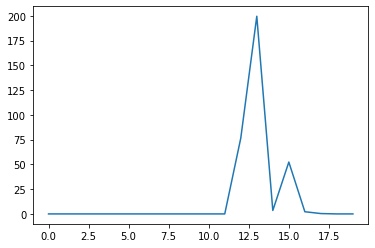

In [39]:
plt.plot(laghist)
plt.show()

In [40]:
# check value of Lagrangian at computed value of theta
print(justlag(restrub.x))

# check how close predicted coefficents are to
# the coefficents used to make the training data
print(nl.norm(restrub.x - cfftrue))

0.0005809200926476481
1.2272680074712519


Prediction vs. Truth:  8.8177224940561
Prediction vs. Training:  8.819287371720655


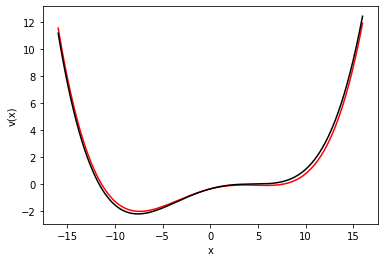

In [45]:
# this code plots the estimated potential against the true potential

# use the machine learned prediction to compute the predicted potential
vturbprdc = gmatplot @ restrub.x

# quantify how close the predicted potential to true potential
print('Prediction vs. Truth: ', nl.norm(vtrue - vturbprdc))

# quantify how close the predicted potential is to the training data
print('Prediction vs. Training: ', nl.norm(reconvtrue - vturbprdc))

# plot the real part of theta
# red = learned potential
# black = true potential
trim = 1
plt.plot(xvec[trim:-trim], vturbprdc[trim:-trim], color='red')
plt.plot(xvec[trim:-trim], vtrue[trim:-trim], color='black')
plt.xlabel('x')
plt.ylabel('v(x)')
plt.show()

---
**Initialize theta with uniform random values**

In [87]:
# uniform random values from the interval [-0.5, 0.5]
# this should be difficult for the optimizer to find a good minimum

cffform = np.random.uniform(size=cfftrue.shape) - 0.5

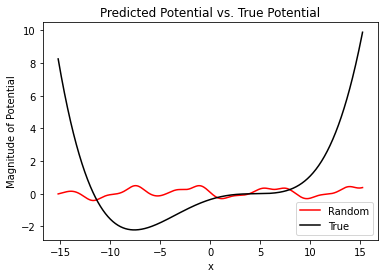

In [89]:
# plot randomly generated coefficents to see what we are starting with

# change randomly initialized coefficients into potential
vrancff = gmatplot @ cffform

# plot real potential vs. initial
# red = random initial potential
# black = true potential
trim = 25
plt.plot(xvec[trim:-trim], vrancff[trim:-trim], color='red', label='Random')
plt.plot(xvec[trim:-trim], vtrue[trim:-trim], color='black', label='True')
plt.xlabel('x')
plt.ylabel('Magnitude of Potential')
#plt.ylim(-100, 1000)
plt.title('Predicted Potential vs. True Potential')
plt.legend()
plt.show()

In [30]:
laghist = np.zeros(laghistlen)
itercnt = 0
resform = so.minimize(justlag, cffform, jac=justgrad, method='BFGS',
                      options={'disp': True, 'maxiter': 100, })

         Current function value: 0.020490
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103


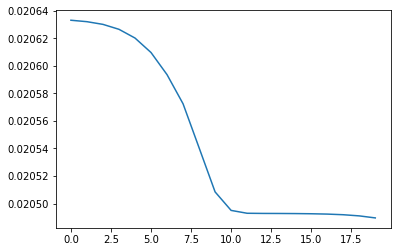

In [31]:
plt.plot(laghist)
plt.show()

Last value of Lagrangian:  0.020489577185037945
Coefficients:  23.635912301149418
Prediction vs. Truth:  106.53043540242939
Prediction vs. Training:  110.91306423969935


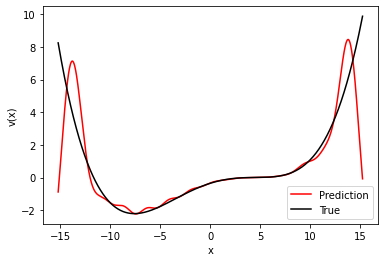

In [32]:
# results

# check value of Lagrangian at computed value of theta
print('Last value of Lagrangian: ', justlag(resform.x))

# check how close predicted coefficents are to
# the coefficents used to make the training data
print('Coefficients: ', nl.norm(resform.x - cfftrue))

# use the machine learned prediction to compute the predicted potential
vformprdc = gmatplot @ resform.x

# quantify how close the predicted potential to true potential
print('Prediction vs. Truth: ', nl.norm(vtrue - vformprdc))

# quantify how close the predicted potential is to the training data
print('Prediction vs. Training: ', nl.norm(reconvtrue - vformprdc))

# red = learned potential
# black = true potential
trim = 25
plt.plot(xvec[trim:-trim], vformprdc[trim:-trim], color='red', label='Prediction')
plt.plot(xvec[trim:-trim], vtrue[trim:-trim], color='black', label='True')
plt.xlabel('x')
plt.ylabel('v(x)')
#plt.ylim(-100, 1000)
plt.legend()
plt.show()

**Propagate System with Found Coefficents**

Element difference:
 [-0.00015448+0.00502113j  0.00904575+0.00404902j  0.01780947+0.00280006j
 ... -0.01746236+0.00663043j -0.0091857 +0.00584j
 -0.00015448+0.00502113j]
Norm of difference: 1.1453485883162655


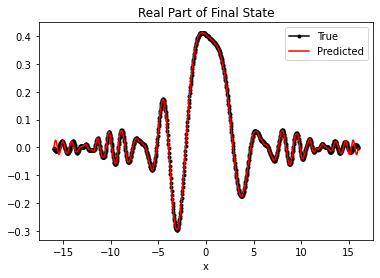

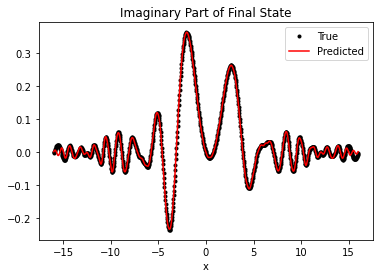

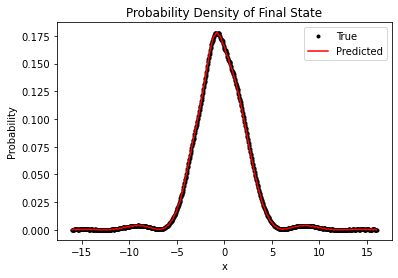

In [30]:
# propagate ainit using the predicted coefficents
_, _, amatform, _ = propa(resform.x, ainit)
    
# transform amat to real space
psimatform = amatform @ convmat

print('Element difference:\n', psimatform[-1] - psimattrue[-1])
print('Norm of difference:', nl.norm(psimatform - psimattrue))

plt.plot(xvec, psimattrue[-1].real, 'k.-', label='True')
plt.plot(xvec, psimatform[-1].real, 'r', label='Predicted')
plt.legend()
plt.title('Real Part of Final State')
plt.xlabel('x')
plt.show()

plt.plot(xvec, psimattrue[-1].imag, 'k.', label='True')
plt.plot(xvec, psimatform[-1].imag, 'r', label='Predicted')
plt.legend()
plt.title('Imaginary Part of Final State')
plt.xlabel('x')
plt.show()

plt.plot(xvec, np.abs(psimattrue[-1])**2, 'k.', label='True')
plt.plot(xvec, np.abs(psimatform[-1])**2, 'r', label='Predicted')
plt.legend()
plt.title('Probability Density of Final State')
plt.xlabel('x')
plt.ylabel('Probability')
plt.show()